In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from PIL import Image

### Load and prepare data

In [2]:
# read in the continuous index csv as DataFrame
cidx = pd.read_csv("./results/cidx_avg.csv", index_col="filename")

# read in images
image_dir = "./stimuli/"
files = [image_dir + filename for filename in cidx.index.values]
images = np.stack([np.array(Image.open(file).convert("L")) for file in files])

# get the mean image
means = np.mean(images, axis=0)

# construct the zero-mean images
zero_mean_images = (images - means).reshape(images.shape[0], -1)

### Create model from Continuous Index

In [3]:
# Perform PCA on the zero-mean images
pca = PCA(n_components=None)
S = pca.fit_transform(zero_mean_images)
A = pca.components_

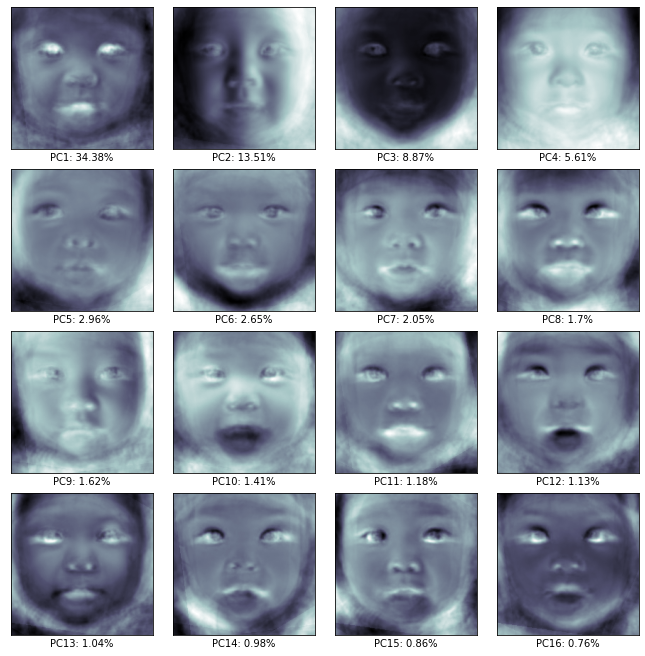

In [4]:
# Display some PCs
A_img = A.reshape(images.shape[0], 200, 200)
fig, ax = plt.subplots(4, 4, figsize=(9,9), constrained_layout=True)
for i in range(0,4):
    for j in range(0,4):
        ax[i,j].imshow( A_img[i * 4 + j]*pca.explained_variance_[i*4+j] + means , cmap="bone")
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].set_xlabel(f"PC{i*4+j+1}: {round(pca.explained_variance_ratio_[i*4+j]*100,2)}%")
plt.savefig("./results/principal_components.png")
plt.show()

In [5]:
n_max = 30
tolerance = 0.003 

# Greedy forward feature selection
features = np.full((images.shape[0]), False)
target = cidx.values
old_score = np.inf
for i in range(n_max):
    # Keep track of scores
    scores = np.full((images.shape[0]), np.inf)

    # calculate MSE for each enabled feature
    for i in range(len(features)):
        # Skip already selected features
        if features[i]:
            continue

        # Temporarily select feature 'i'
        features[i] = True

        # get reconstruction
        comps = pca.components_[features]
        X = zero_mean_images @ comps.T
        
        # Fit regression
        lr = LinearRegression()
        lr.fit(X, target)
        scores[i] = mean_squared_error(lr.predict(X),target)

        # Deselect feature 'i'
        features[i] = False
    
    # Pick feature with the lowest MSE-score if it improves
    # otherwise feature selection is done
    min_score = scores.min()
    if min_score + tolerance < old_score:
        features[scores.argmin()] = True
        old_score = min_score
        print(min_score)
    else:
        break

0.2925814661385568
0.2749384147007329
0.2606128210926957
0.24726194132883042
0.23405955265823
0.22246579880525977
0.21318829632369868
0.20442954892151785
0.19630270575235034
0.1884045186978955
0.18076828629695205
0.1733243468220722
0.16589363001120214
0.15994962232738733
0.15527062282919962
0.15089339921664843
0.14683867651695756
0.14278524206245588
0.13902105772024248
0.13543161258478956
0.13187350287491026
0.12851999373930734
0.12518478224060683
0.12192827317313108
0.11871228960310959
0.1155304613872061


Get model parameters

In [6]:
# Fit linear regression using only selected features
comps = pca.components_[features]
X = zero_mean_images @ comps.T
lr = LinearRegression()
lr.fit(X, target)

# Extract model paramters
B = lr.coef_.T
d = lr.intercept_

Generate images across the continuous index

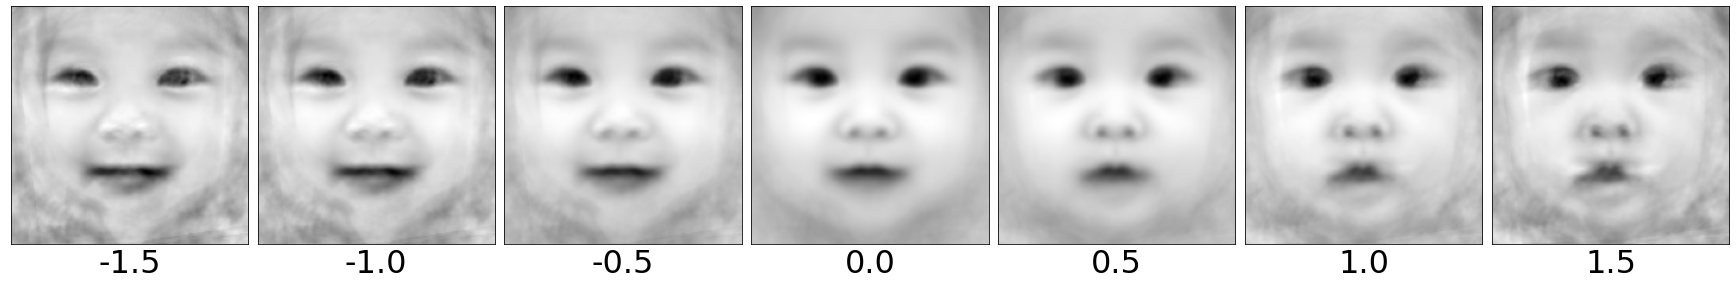

In [7]:
# define a continuous index range to generate images for
cidx_range = np.array([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])

# generate and display images for the defined range
fig, ax = plt.subplots(1, len(cidx_range), constrained_layout=True, figsize=(24,6))
for i in range(len(cidx_range)):
    img = ((cidx_range[i] - d) @ np.linalg.pinv(B) @ np.linalg.pinv(comps.T)).reshape(200, 200) + means
    ax[i].imshow(img, cmap="gray")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xlabel(f"{cidx_range[i]}", fontsize=32)
plt.savefig("./results/cidx_generated_images.png", bbox_inches="tight")
plt.show()

### Generate Continuum from mean images

In [8]:
# Compute the mean smiling and non-smiling images
mask = (cidx.values > 0).flatten()
mean_nosmile_images = images[mask].mean(axis=0)
mean_smile_images = images[~mask].mean(axis=0)

# Create direction vector between the two means
direction_vector = mean_nosmile_images - mean_smile_images

# Create a step vector
steps = np.linspace(-0.5, 1.5, 7)

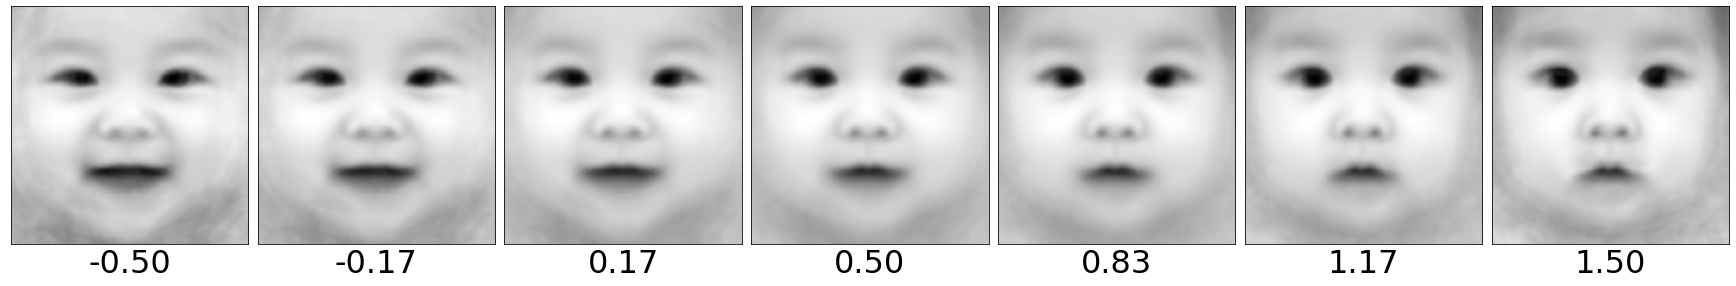

In [9]:
# Generate and display images between the two mean images, and an outlier for each
fig, ax = plt.subplots(1, len(steps), constrained_layout=True, figsize=(24, 6))
for i in range(len(steps)):
    img = mean_smile_images + steps[i] * direction_vector
    ax[i].imshow(img, cmap = "gray")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xlabel("{:.2f}".format(steps[i]), fontsize=32)
plt.savefig("./results/mean_generated_images.png", bbox_inches="tight")
plt.show()

### Generate Continuum from mean of reconstructed images

In [10]:
# Get reconstructed images from PCA, 
# capturing 90% explained variance
pca = PCA(n_components=0.9)
S = pca.fit_transform(zero_mean_images)
A = pca.components_
X = (S @ A).reshape(-1, 200, 200) + means

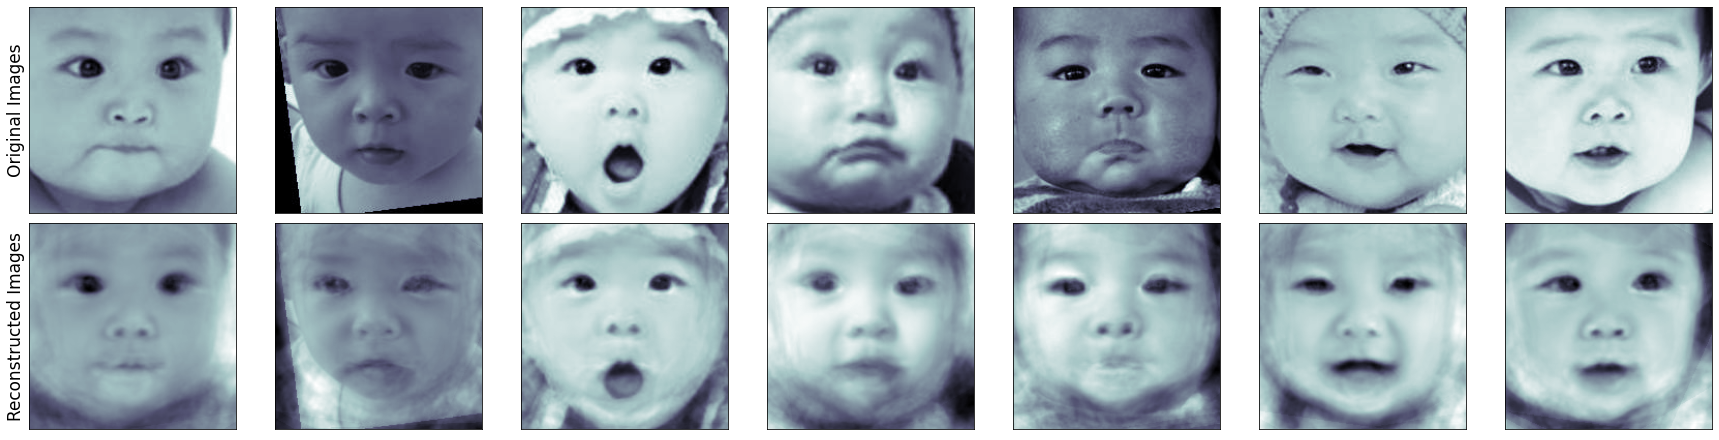

In [11]:
# Display 7 random baby images and their reconstruction
n_bebs = 7
img_idx = np.random.choice(len(images), size=n_bebs)
fig, ax = plt.subplots(2, n_bebs, constrained_layout=True, figsize=(24, 6))
for i in range(n_bebs):
    idx = img_idx[i]
    ax[0, i].imshow(images[idx], cmap='bone')
    ax[1, i].imshow(X[idx], cmap='bone')
    for j in range(2):
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[0, 0].set_ylabel('Original Images', fontsize=17)
ax[1, 0].set_ylabel('Reconstructed Images', fontsize=17)
plt.savefig("./results/img_reconstructions.png", bbox_inches="tight")
plt.show()

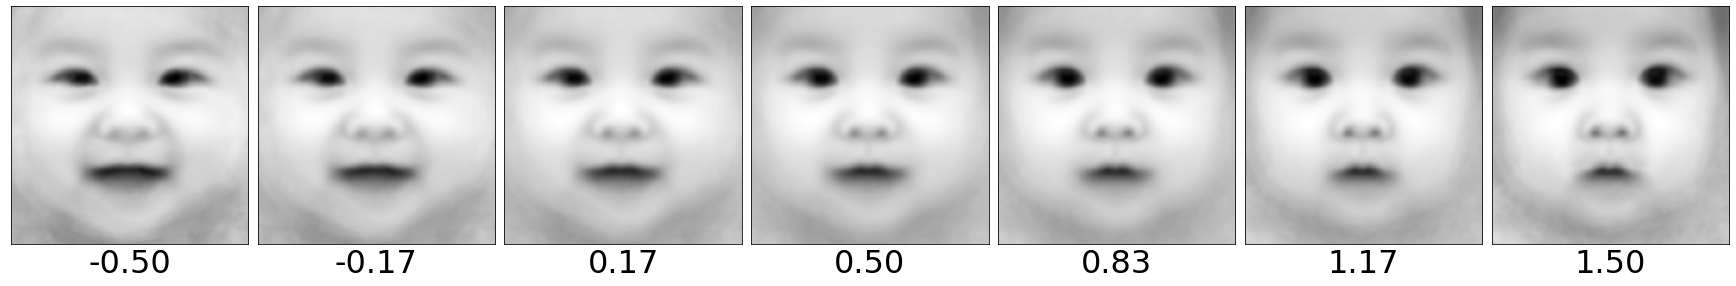

In [12]:
# Calculate mean of reconstructed images
mean_nosmile_images_recon = X[mask].mean(axis=0)
mean_smile_images_recon = X[~mask].mean(axis=0)

# Create direction vector between the two means
direction_vector = mean_nosmile_images_recon - mean_smile_images_recon

# Generate and display images between the two mean reconstructed images, and an outlier for each
fig, ax = plt.subplots(1, len(steps), constrained_layout=True, figsize=(24,6))
for i in range(len(steps)):
    img = mean_smile_images_recon + steps[i] * direction_vector
    ax[i].imshow(img, cmap = "gray")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xlabel("{:.2f}".format(steps[i]), fontsize=32)
plt.savefig("./results/mean_generated_recon_images.png", bbox_inches="tight")
plt.show()